In [3]:
import pandas as pd
import numpy as np
import aiobotocore

In [4]:
#load the file

bucket='mtw-sm-decljunc-dev'
folder= 'declaracoes'
data_key = 'Declarações Federais - EFD - ICMS-IPI - C100, C170 - Documento e Itens - Nota Fiscal - DB Parte2.csv'
data_location = 's3://{}/{}/{}'.format(bucket, folder, data_key)

df = pd.read_csv(data_location)

,UF Origem,UF Destino,Vlr ICMS - C100,NCM,Descrição Complementar
0,SP,SP,2.43,NaN,NaN
1,SP,SP,8.00,NaN,NaN
2,SP,SP,3.03,NaN,NaN
3,SP,SP,9.57,NaN,NaN
4,SP,SP,8.00,NaN,NaN


In [5]:
from sklearn import decomposition, ensemble
df.dropna(inplace = True)

,UF Origem,UF Destino,Vlr ICMS - C100,NCM,Descrição Complementar
413,SP,SP,0.00,7051900.0,MIX DE FOLHAS PICADAS
538,SP,SP,5.48,9041100.0,PIMENTAO VERDE CUBO 10
539,SP,SP,2.74,9041100.0,PIMENTAO VERMELHO CUBO 10
540,SP,SP,5.48,9041100.0,PIMENTAO VERMELHO CUBO 10
550,SP,SP,2.74,20021000.0,TOMATE GOMO COM SEMENTE 1/8


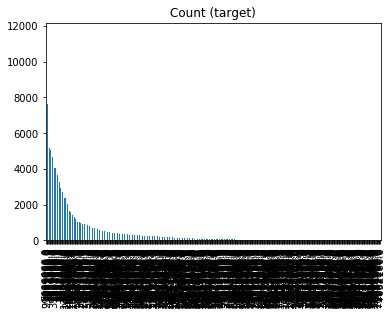

In [7]:
# Check for imbalances in the data
Z["NCM"].value_counts().plot(kind='bar', title='Count (target)');

In [8]:
y = df["NCM"]

In [9]:
X = df["Descrição Complementar"]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# create a count vectorizer object 
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')


tfidf_vect.fit(X)

# transform the training data using count vectorizer object for Descriptions
tfidf_vec_Descriptions = tfidf_vect.transform(X)
X = tfidf_vec_Descriptions

In [14]:
#Testing Algorithm 1

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
stf = StratifiedKFold(n_splits=3, random_state=1234, shuffle = True)
stf.get_n_splits(X,y)
scoresss = []
f1_Algo1= []
for train, test in stf.split(X,y):
    x_train, x_test = X[train], X[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    lit = LGBMClassifier(n_estimators= 30 ,reg_lambda=25)
    lit.fit(X,y,eval_set=[(x_train,y_train), (x_test,y_test)],early_stopping_rounds= 1000, eval_metric  = 'logloss',
            
           
            )
    scoresss.append(accuracy_score(y_test,lit.predict(x_test)))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 2.48074	valid_1's multi_logloss: 2.48448
[2]	valid_0's multi_logloss: 1.98092	valid_1's multi_logloss: 1.98448
[3]	valid_0's multi_logloss: 1.6427	valid_1's multi_logloss: 1.64599
[4]	valid_0's multi_logloss: 1.38961	valid_1's multi_logloss: 1.39265
[5]	valid_0's multi_logloss: 1.19221	valid_1's multi_logloss: 1.1952
[6]	valid_0's multi_logloss: 1.03361	valid_1's multi_logloss: 1.03662
[7]	valid_0's multi_logloss: 0.904062	valid_1's multi_logloss: 0.907133
[8]	valid_0's multi_logloss: 0.797079	valid_1's multi_logloss: 0.800198
[9]	valid_0's multi_logloss: 0.707579	valid_1's multi_logloss: 0.710667
[10]	valid_0's multi_logloss: 0.632215	valid_1's multi_logloss: 0.635345
[11]	valid_0's multi_logloss: 0.568419	valid_1's multi_logloss: 0.57155
[12]	valid_0's multi_logloss: 0.513973	valid_1's multi_logloss: 0.517074
[13]	valid_0's multi_logloss: 0.466885	valid_1's multi_logloss: 0.469969
[14]	valid_0's multi_logloss: 0.426473	valid_1's multi_logloss: 0.429509
[1

In [15]:
f1_Algo1.append(f1_score(y_test,lit.predict(x_test),  average='micro'))

In [16]:
import numpy as np
np.mean(scoresss)

0.9661296186360729

In [17]:
np.mean(f1_Algo1)

0.9660237736943106

In [18]:
score_train = lit.score(x_train, y_train)
score_test = lit.score(x_test, y_test)

In [19]:
print("Accuracy train set:", score_train)
print("Accuracy test set:", score_test)

Accuracy train set: 0.966182541106954
Accuracy test set: 0.9660237736943106


In [ ]:
# Check how well the model Classified the data
from sklearn.metrics import classification_report , confusion_matrix
import seaborn as sns
lr_pred = lit.predict(x_test)
con_matrix = np.array(confusion_matrix(y_test, lr_pred ))
print("Confusion matrix:\n" , con_matrix)
sns.heatmap(con_matrix, annot =True)
class_report = classification_report(y_test, lr_pred,
                                    )
print("Classification report : \n" , class_report)

In [ ]:
#run only cells above
####
#